In [1]:
# importe
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [2]:
# importe de archivo
loan_data = pd.read_csv('loan_data_2007_2014.csv')

C:\Users\D3YN3R\AppData\Local\Temp\ipykernel_13836\2146513411.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv('loan_data_2007_2014.csv')


In [3]:
loan_data.dropna(thresh = loan_data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

In [4]:
loan_data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title',
                          'zip_code', 'next_pymnt_d', 'recoveries', 'collection_recovery_fee',
                          'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

In [5]:
# Se exploran los valores unicos de la columna loan_status
loan_data['loan_status'].value_counts(normalize = True)

# Se crea una columna binaria basada en loan_status que servira como target
loan_data['good_bad'] = np.where(loan_data.loc[:, 'loan_status'].isin(['Charged Off', 'Default',
                                                                       'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']),0, 1)
loan_data.drop(columns = ['loan_status'], inplace = True)

In [6]:
# Division del dataframe en test y train
X = loan_data.drop('good_bad', axis = 1)
y = loan_data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)
X_train, X_test = X_train.copy(), X_test.copy()

In [7]:
# Se limpia la variable emp_length, se asignan 0 a los datos N/A y se convierten a numericos
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

# Se crean columnas a base de la diferencia de las columnas fechas y la fecha actual

def date_columns(df, column):
    today_date = pd.to_datetime('2020-08-01')
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / 
							np.timedelta64(1, 'M')))
    df['mths_since_' + column] = df['mths_since_' + column].apply(
		lambda x: df['mths_since_' + column].max() if x < 0 else x)
    df.drop(columns = [column], inplace = True)

# Limpieza de la variable term y conversion a numerico
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

# Aplicacion a train
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')
emp_length_converter(X_train, 'emp_length')
loan_term_converter(X_train, 'term')

C:\Users\D3YN3R\AppData\Local\Temp\ipykernel_13836\241738822.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\+ years', '')


c:\Users\D3YN3R\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\D3YN3R\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


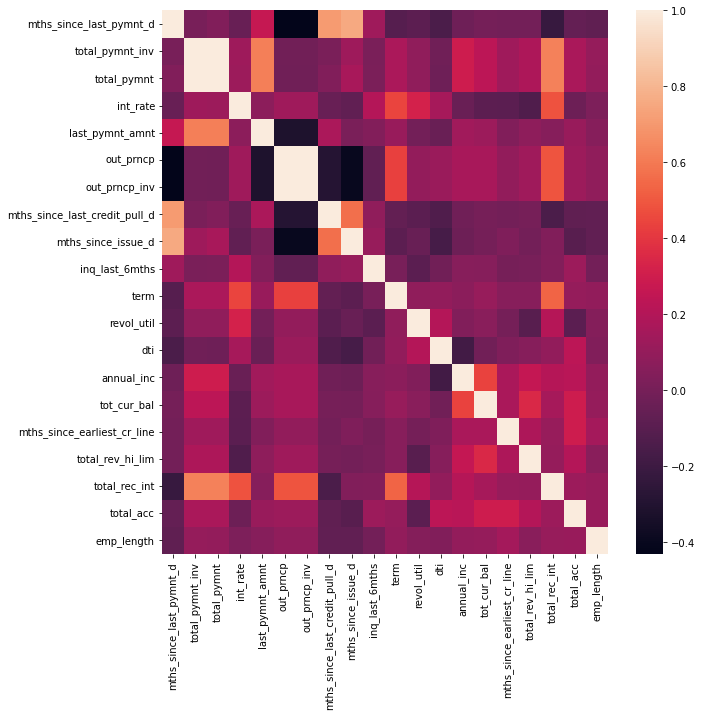

In [8]:
# Se divide el dataset con el fin de descartar variables
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()
chi2_check = {}

# Se calcula el chi cuadrado para las variables categóricas
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

# Se rellenan los N/A con la media numerica para evitar problemas funcionales
X_train_num.fillna(X_train_num.mean(), inplace = True)

# Se calcula el F estadistico y el P valor correspondiente
F_statistic, p_values = f_classif(X_train_num, y_train)

#Se calcula la tabla anova para los datos númericos
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,
					'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

# Se guardan los primeros 20 datos
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()

# Se calcula la matrix de correlación con los datos resultantes
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)

# Se eliminan las variables descartadas
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])
def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)
col_to_drop(X_train, drop_columns_list)

In [9]:
# Se mejora el dataset de test mediante la insercion de variables ficticias
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df
X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])
emp_length_converter(X_test, 'emp_length')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')
loan_term_converter(X_test, 'term')
col_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

C:\Users\D3YN3R\AppData\Local\Temp\ipykernel_13836\241738822.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\+ years', '')


In [10]:
# Calculo de WoE y IV

def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

'''
function to calculate WoE & IV of continuous variables
This is same as the function we defined earlier for discrete variables
The only difference are the 2 commented lines of code in the function that results in the df
being sorted by continuous variable values
'''
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

# We set the default style of the graphs to the seaborn style. 
sns.set()
# function to plot WoE value
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 
                  'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G']	

# custom transformer class to create new categorical dummy features
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        X_new['purpose:debt_consolidation'] = X.loc[:,'purpose:debt_consolidation']
        X_new['purpose:credit_card'] = X.loc[:,'purpose:credit_card']
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['purpose:educ__ren_en__sm_b__mov'] = sum([X['purpose:educational'], X['purpose:renewable_energy'], X['purpose:small_business'], 
                                                        X['purpose:moving']])
        X_new['purpose:vacation__house__wedding__med__oth'] = sum([X['purpose:vacation'], X['purpose:house'], X['purpose:wedding'], 
                                                                   X['purpose:medical'], X['purpose:other']])
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
        X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
        X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
        X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
        X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
        X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)
        X_new['total_pymnt:<10,000'] = np.where((X['total_pymnt'] <= 10000), 1, 0)
        X_new['total_pymnt:10,000-15,000'] = np.where((X['total_pymnt'] > 10000) & (X['total_pymnt'] <= 15000), 1, 0)
        X_new['total_pymnt:15,000-20,000'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 20000), 1, 0)
        X_new['total_pymnt:20,000-25,000'] = np.where((X['total_pymnt'] > 20000) & (X['total_pymnt'] <= 25000), 1, 0)
        X_new['total_pymnt:>25,000'] = np.where((X['total_pymnt'] > 25000), 1, 0)
        X_new['total_rec_int:<1,089'] = np.where((X['total_rec_int'] <= 1089), 1, 0)
        X_new['total_rec_int:1,089-2,541'] = np.where((X['total_rec_int'] > 1089) & (X['total_rec_int'] <= 2541), 1, 0)
        X_new['total_rec_int:2,541-4,719'] = np.where((X['total_rec_int'] > 2541) & (X['total_rec_int'] <= 4719), 1, 0)
        X_new['total_rec_int:4,719-7,260'] = np.where((X['total_rec_int'] > 4719) & (X['total_rec_int'] <= 7260), 1, 0)
        X_new['total_rec_int:>7,260'] = np.where((X['total_rec_int'] > 7260), 1, 0)
        X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
        X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
        X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
        X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
        X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
        X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
        X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
        X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
        X_new['mths_since_earliest_cr_line:missing'] = np.where(X['mths_since_earliest_cr_line'].isnull(), 1, 0)
        X_new['mths_since_earliest_cr_line:<125'] = np.where((X['mths_since_earliest_cr_line'] <= 125), 1, 0)
        X_new['mths_since_earliest_cr_line:125-167'] = np.where((X['mths_since_earliest_cr_line'] > 125) & (X['mths_since_earliest_cr_line'] <= 167), 1, 0)
        X_new['mths_since_earliest_cr_line:167-249'] = np.where((X['mths_since_earliest_cr_line'] > 167) & (X['mths_since_earliest_cr_line'] <= 249), 1, 0)
        X_new['mths_since_earliest_cr_line:249-331'] = np.where((X['mths_since_earliest_cr_line'] > 249) & (X['mths_since_earliest_cr_line'] <= 331), 1, 0)
        X_new['mths_since_earliest_cr_line:331-434'] = np.where((X['mths_since_earliest_cr_line'] > 331) & (X['mths_since_earliest_cr_line'] <= 434), 1, 0)
        X_new['mths_since_earliest_cr_line:>434'] = np.where((X['mths_since_earliest_cr_line'] > 434), 1, 0)
        X_new['mths_since_issue_d:<79'] = np.where((X['mths_since_issue_d'] <= 79), 1, 0)
        X_new['mths_since_issue_d:79-89'] = np.where((X['mths_since_issue_d'] > 79) & (X['mths_since_issue_d'] <= 89), 1, 0)
        X_new['mths_since_issue_d:89-100'] = np.where((X['mths_since_issue_d'] > 89) & (X['mths_since_issue_d'] <= 100), 1, 0)
        X_new['mths_since_issue_d:100-122'] = np.where((X['mths_since_issue_d'] > 100) & (X['mths_since_issue_d'] <= 122), 1, 0)
        X_new['mths_since_issue_d:>122'] = np.where((X['mths_since_issue_d'] > 122), 1, 0)
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<56'] = np.where((X['mths_since_last_credit_pull_d'] <= 56), 1, 0)
        X_new['mths_since_last_credit_pull_d:56-61'] = np.where((X['mths_since_last_credit_pull_d'] > 56) & (X['mths_since_last_credit_pull_d'] <= 61), 1, 0)
        X_new['mths_since_last_credit_pull_d:61-75'] = np.where((X['mths_since_last_credit_pull_d'] > 61) & (X['mths_since_last_credit_pull_d'] <= 75), 1, 0)
        X_new['mths_since_last_credit_pull_d:>75'] = np.where((X['mths_since_last_credit_pull_d'] > 75), 1, 0)
        X_new.drop(columns = ref_categories, inplace = True)
        return X_new

In [11]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

In [12]:
# fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0            5000         5000           4975.0   36 months     10.65   
1            2500         2500           2500.0   60 months     15.27   
2            2400         2400           2400.0   36 months     15.96   
3           10000        10000          10000.0   36 months     13.49   
4            3000         3000           3000.0   60 months     12.69   
...           ...          ...              ...         ...       ...   
466280      18400        18400          18400.0   60 months     14.47   
466281      22000        22000          22000.0   60 months     19.97   
466282      20700        20700          20700.0   60 months     1...
        acc_now_delinq tot_coll_amt  tot_cur_bal  total_rev_hi_lim  
0                  0.0          NaN          NaN               NaN  
1                  0.0          NaN          NaN               NaN  
2           

In [13]:
# create a summary table
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients'
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)

In [14]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index

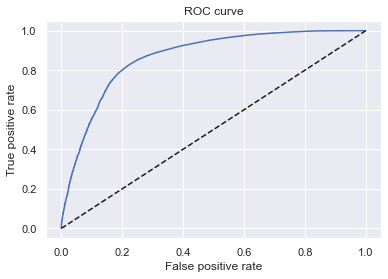

In [35]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], 
                                 y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

AUROC: 0.8662
Gini: 0.7323


Text(0.5, 1.0, 'PR curve')

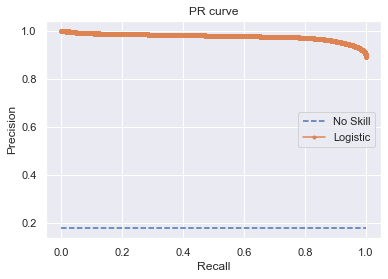

In [36]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
# print AUROC and Gini
print('AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (Gini))

# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# get the values required to plot a PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], 
                                                       y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve')

# Scorecard

In [56]:
summary_table

,Feature name,Coefficients
0,Intercept,2.946137
1,grade:A,0.979999
2,grade:B,0.792810
3,grade:C,0.609483
4,grade:D,0.487582
5,grade:E,0.331940
6,grade:F,0.190517
7,home_ownership:OWN,-0.048503
8,home_ownership:OTHER_NONE_RENT,-0.104289
9,verification_status:Source Verified,-0.281461


In [57]:
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature name,Coefficients
0,mths_since_last_credit_pull_d:>75,0
1,mths_since_issue_d:>122,0
2,mths_since_earliest_cr_line:>434,0
3,"total_rev_hi_lim:>79,780",0
4,"total_rec_int:>7,260",0
5,"total_pymnt:>25,000",0
6,"out_prncp:>15,437",0
7,revol_util:>1.0,0
8,inq_last_6mths:>4,0
9,dti:>35.191,0


In [58]:
# Concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,2.946137
1,1,grade:A,0.979999
2,2,grade:B,0.792810
3,3,grade:C,0.609483
4,4,grade:D,0.487582
5,5,grade:E,0.331940
6,6,grade:F,0.190517
7,7,home_ownership:OWN,-0.048503
8,8,home_ownership:OTHER_NONE_RENT,-0.104289
9,9,verification_status:Source Verified,-0.281461


In [59]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,2.946137,Intercept
1,1,grade:A,0.979999,grade
2,2,grade:B,0.792810,grade
3,3,grade:C,0.609483,grade
4,4,grade:D,0.487582,grade
5,5,grade:E,0.331940,grade
6,6,grade:F,0.190517,grade
7,7,home_ownership:OWN,-0.048503,home_ownership
8,8,home_ownership:OTHER_NONE_RENT,-0.104289,home_ownership
9,9,verification_status:Source Verified,-0.281461,verification_status


In [60]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [61]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,2.946137,Intercept,598.716975,599.0
1,1,grade:A,0.979999,grade,24.486461,24.0
2,2,grade:B,0.792810,grade,19.809316,20.0
3,3,grade:C,0.609483,grade,15.228689,15.0
4,4,grade:D,0.487582,grade,12.182823,12.0
5,5,grade:E,0.331940,grade,8.293939,8.0
6,6,grade:F,0.190517,grade,4.760297,5.0
7,7,home_ownership:OWN,-0.048503,home_ownership,-1.211904,-1.0
8,8,home_ownership:OTHER_NONE_RENT,-0.104289,home_ownership,-2.605787,-3.0
9,9,verification_status:Source Verified,-0.281461,verification_status,-7.032655,-7.0


In [62]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

301.0
851.0


In [63]:
# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
pd.options.display.max_rows = 102
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,2.946137,Intercept,598.716975,599.0,0.283025
1,1,grade:A,0.979999,grade,24.486461,24.0,-0.486461
2,2,grade:B,0.792810,grade,19.809316,20.0,0.190684
3,3,grade:C,0.609483,grade,15.228689,15.0,-0.228689
4,4,grade:D,0.487582,grade,12.182823,12.0,-0.182823
5,5,grade:E,0.331940,grade,8.293939,8.0,-0.293939
6,6,grade:F,0.190517,grade,4.760297,5.0,0.239703
7,7,home_ownership:OWN,-0.048503,home_ownership,-1.211904,-1.0,0.211904
8,8,home_ownership:OTHER_NONE_RENT,-0.104289,home_ownership,-2.605787,-3.0,-0.394213
9,9,verification_status:Source Verified,-0.281461,verification_status,-7.032655,-7.0,0.032655


In [64]:
# look like we can get by deducting 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 598
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,2.946137,Intercept,598.716975,599.0,0.283025,598.0
1,1,grade:A,0.979999,grade,24.486461,24.0,-0.486461,24.0
2,2,grade:B,0.792810,grade,19.809316,20.0,0.190684,20.0
3,3,grade:C,0.609483,grade,15.228689,15.0,-0.228689,15.0
4,4,grade:D,0.487582,grade,12.182823,12.0,-0.182823,12.0
5,5,grade:E,0.331940,grade,8.293939,8.0,-0.293939,8.0
6,6,grade:F,0.190517,grade,4.760297,5.0,0.239703,5.0
7,7,home_ownership:OWN,-0.048503,home_ownership,-1.211904,-1.0,0.211904,-1.0
8,8,home_ownership:OTHER_NONE_RENT,-0.104289,home_ownership,-2.605787,-3.0,-0.394213,-3.0
9,9,verification_status:Source Verified,-0.281461,verification_status,-7.032655,-7.0,0.032655,-7.0


In [65]:
# Recheck min and max possible scores
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

300.0
850.0


In [66]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:OTHER_NONE_RENT,verification_status:Source Verified,...,mths_since_earliest_cr_line:249-331,mths_since_earliest_cr_line:331-434,mths_since_issue_d:<79,mths_since_issue_d:79-89,mths_since_issue_d:89-100,mths_since_issue_d:100-122,mths_since_last_credit_pull_d:missing,mths_since_last_credit_pull_d:<56,mths_since_last_credit_pull_d:56-61,mths_since_last_credit_pull_d:61-75
395346,1,0,0,1,0,0,0,1,0,1,...,0,1,1,0,0,0,0,1,0,0
376583,1,1,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0
297790,1,0,0,1,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
47347,1,0,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
446772,1,0,0,0,1,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1


In [67]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 85)
(102,)


In [68]:
# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard, it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(102, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 102)
(102, 1)


In [69]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
395346,507.0
376583,579.0
297790,534.0
47347,553.0
446772,466.0


In [80]:
y_scores




,0
395346,507.0
376583,579.0
297790,534.0
47347,553.0
446772,466.0
...,...
32147,547.0
78936,569.0
459582,509.0
454915,558.0


In [91]:
#y_scores.columns.values
#y_scores[[0]]

df1 = y_scores[y_scores[0] >= 630]
df1

,0
21993,649.0
383687,638.0
16444,634.0
378542,648.0
97599,639.0
...,...
392988,638.0
143497,649.0
433700,649.0
440877,650.0
